
# Plot Metrics from `results/generated_*`

This notebook scans folders like `results/generated_5`, `results/generated_10`, ..., `results/generated_60`,
reads each `metrics.csv` (columns: `total_waiting_time,total_energy_waste`), and produces **two bar charts**:

1. **Energy Waste vs Folder** — y = `total_energy_waste`, x = folder number (5,10,...,60).
2. **Waiting Time vs Folder** — y = `total_waiting_time`, x = folder number (5,10,...,60).

The figures are also saved to `results/plots/`.


In [9]:

import os
import re
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# Inline plots
%matplotlib inline


In [10]:

# Change this if needed
results_dir = Path('results')    # directory containing generated_* folders
output_dir  = results_dir / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)
print('Results dir:', results_dir.resolve())
print('Output dir :', output_dir.resolve())


Results dir: D:\Archive\.projects\SPARS\SPARS\results
Output dir : D:\Archive\.projects\SPARS\SPARS\results\plots


In [11]:

def collect_metrics(results_dir: Path):
    import re, pandas as pd, os
    pat = re.compile(r'^generated_(\d+)$')
    rows = []
    for entry in results_dir.iterdir():
        if not entry.is_dir():
            continue
        m = pat.match(entry.name)
        if not m:
            continue
        k = int(m.group(1))
        csv_path = entry / 'metrics.csv'
        if not csv_path.is_file():
            continue
        try:
            df = pd.read_csv(csv_path)
        except Exception as e:
            print(f"[WARN] Failed to read {csv_path}: {e}")
            continue
        cols = [c.lower().strip() for c in df.columns.tolist()]
        if 'total_waiting_time' in cols and 'total_energy_waste' in cols:
            tw = float(df['total_waiting_time'].iloc[0])
            te = float(df['total_energy_waste'].iloc[0])
        else:
            try:
                tw = float(df.iloc[0, 0])
                te = float(df.iloc[0, 1])
            except Exception as e:
                print(f"[WARN] Bad format in {csv_path}: {e}")
                continue
        rows.append((k, te, tw))
    rows.sort(key=lambda x: x[0])
    return rows

def plot_bars(xs, ys, xlabel, ylabel, title, out_path):
    import matplotlib.pyplot as plt
    import numpy as np

    # Map x labels to dense positions so bars are wider visually
    idx = np.arange(len(xs))
    fig, ax = plt.subplots()
    bars = ax.bar(idx, ys, width=0.9)  # wider bars

    # X ticks as the folder numbers
    ax.set_xticks(idx, [str(x) for x in xs])
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

    # Choose label format: integers -> %d, else -> %.2f
    if all(float(y).is_integer() for y in ys):
        fmt = '%d'
    else:
        fmt = '%.2f'

    # Add value labels above bars
    for rect, y in zip(bars, ys):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2.0, height,
                fmt % y,
                ha='center', va='bottom', fontsize=8, rotation=0)

    fig.tight_layout()
    fig.savefig(out_path, dpi=150)
    plt.show()


,folder,total_energy_waste,total_waiting_time
0,5,198009.0,75827.0
1,10,243501.0,74389.0
2,15,276123.0,74086.0
3,20,292158.0,73842.0
4,25,345027.0,72970.0
5,30,339186.0,72492.0
6,35,350580.0,72301.0
7,40,371484.0,72229.0
8,45,426585.0,73823.0
9,50,467412.0,73528.0


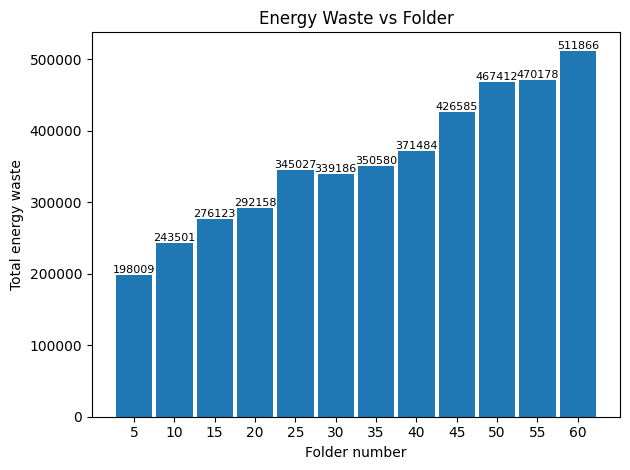

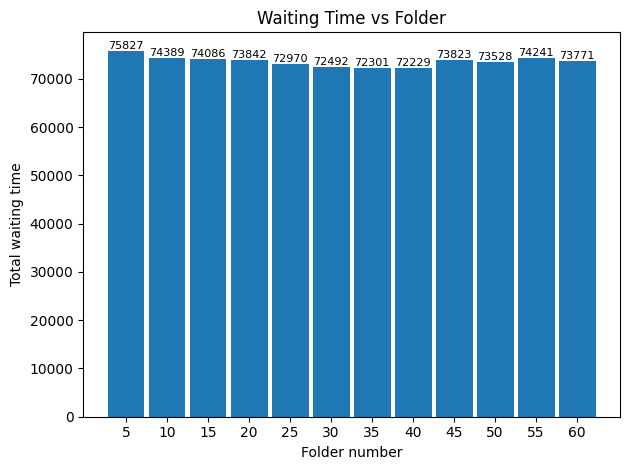

Saved: results\plots\summary.csv
Saved: results\plots\energy_waste_bar.png
Saved: results\plots\waiting_time_bar.png


In [12]:

rows = collect_metrics(results_dir)
if not rows:
    raise SystemExit(f"No metrics found under {results_dir}/generated_*/metrics.csv")

xs  = [r[0] for r in rows]
tew = [r[1] for r in rows]  # total_energy_waste
twt = [r[2] for r in rows]  # total_waiting_time

# Save a summary table (optional)
summary = pd.DataFrame({'folder': xs, 'total_energy_waste': tew, 'total_waiting_time': twt})
summary_path = output_dir / 'summary.csv'
summary.to_csv(summary_path, index=False)
display(summary)

# Plot 1: Energy waste bars
plot_bars(xs, tew, 'Folder number', 'Total energy waste',
          'Energy Waste vs Folder', output_dir / 'energy_waste_bar.png')

# Plot 2: Waiting time bars
plot_bars(xs, twt, 'Folder number', 'Total waiting time',
          'Waiting Time vs Folder', output_dir / 'waiting_time_bar.png')

print("Saved:", summary_path)
print("Saved:", output_dir / 'energy_waste_bar.png')
print("Saved:", output_dir / 'waiting_time_bar.png')
